In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, h, k, epsilon_0
from scipy.special import voigt_profile

In [2]:
def optical_depth_MOT(diameter, atom_number, cross_section=1.4e-13):
    density = (3/4) * atom_number / (np.pi * (diameter / 2)**3)
    return density * cross_section * diameter

# def lorentzian(x, gamma):
#     return gamma / (np.pi * (x**2 + gamma**2))

# def gaussian(x, sigma):
#     return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

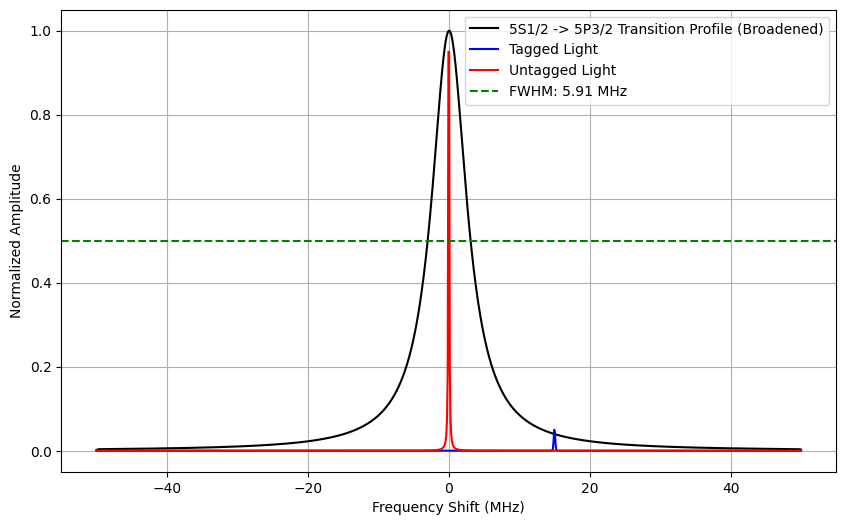

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, h, k, epsilon_0, atomic_mass

# constants
wavelength = 780.241e-9  # m (D2 line)
wavevector = 2 * np.pi / wavelength
gamma = 6.065 * 1e6  # Hz
mass = 87 * atomic_mass # kg
    
# parameters
temperature = 0.0001 # Kelvin
atom_number = 1e8
diameter = 0.005 # meter

v_thermal = np.sqrt(2 * k * temperature / mass)
doppler_width = wavevector * v_thermal / (2 * np.pi)

# variables
ultrasound_freq = 15 * 1e6 # Hz
freq_range = np.linspace(-50, 50, 1000) * 1e6

laser_detuning = 0 * 1e6 # Hz
us_linewidth = 100 * 1e3 # Hz

# simulation
lorentzian = gamma / (2 * np.pi) / ((freq_range**2) + (gamma/2)**2)
lorentzian = lorentzian / np.max(lorentzian)

# doppler broadening from non-zero temperature
gaussian_doppler = np.exp(-freq_range**2 / (2 * doppler_width**2))
gaussian_doppler = gaussian_doppler / np.max(gaussian_doppler)

voigt_profile = np.convolve(lorentzian, gaussian_doppler, mode='same')
voigt_profile = voigt_profile / np.max(voigt_profile)

# untagged light
laser_linewidth = 100 * 1e3  # 100 kHz in Hz
untagged_power = 0.95
untagged_lorentzian = (laser_linewidth/2)**2 / (((freq_range - laser_detuning)**2) + (laser_linewidth/2)**2)
untagged_lorentzian = untagged_lorentzian / np.max(untagged_lorentzian)  # Normalize


# tagged light
sideband_power = 0.05  # 5% of main beam power
sideband_gaussian = np.exp(-(freq_range - ultrasound_freq)**2 / (2 * (us_linewidth)**2))
sideband_gaussian = sideband_gaussian / np.max(sideband_gaussian)


plt.figure(figsize=(10, 6))
plt.plot(freq_range/1e6, voigt_profile, 'k-', label='5S1/2 -> 5P3/2 Transition Profile (Broadened)' )
plt.plot(freq_range/1e6, sideband_power * sideband_gaussian, 'b-', label='Tagged Light')
plt.plot(freq_range/1e6, untagged_power * untagged_lorentzian, 'r-', label='Untagged Light')


fwhm_value = 0.5 
fwhm_indices = np.where(lorentzian >= fwhm_value)[0]
fwhm_width = np.abs(freq_range[fwhm_indices[0]] - freq_range[fwhm_indices[-1]]) / 1e6
plt.axhline(y=fwhm_value, color='green', linestyle='--', 
            label=f'FWHM: {fwhm_width:.2f} MHz')

plt.xlabel('Frequency Shift (MHz)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()


10.695212175775366


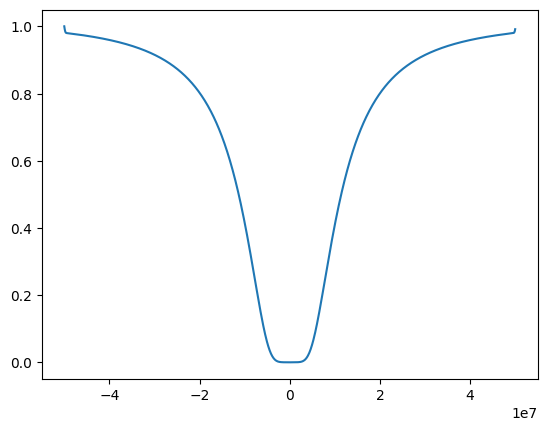

0.002760803306294211
0.6672196248992324
0.9958792776772767


In [22]:
from scipy.integrate import simpson

optical_depth = optical_depth_MOT(diameter, atom_number=1e9)
print (optical_depth)

transmission_profile = np.exp(-optical_depth * voigt_profile)
transmission_profile = transmission_profile / np.max(transmission_profile)

plt.plot(freq_range, transmission_profile)
plt.show()

transmitted_light = untagged_power * untagged_lorentzian * transmission_profile 
transmitted_tagged_light = sideband_power * sideband_gaussian * transmission_profile

fractional_untagged_power = simpson(transmitted_light, freq_range) / simpson(untagged_power * untagged_lorentzian, freq_range)
fractional_tagged_power = simpson(transmitted_tagged_light, freq_range) / simpson(sideband_power * sideband_gaussian, freq_range)

print (simpson(transmitted_light, freq_range) / simpson(untagged_power * untagged_lorentzian, freq_range))
print (simpson(transmitted_tagged_light, freq_range) / simpson(sideband_power * sideband_gaussian, freq_range))

optical_snr = fractional_tagged_power / (fractional_untagged_power + fractional_tagged_power)
print (optical_snr)

# photon counting
laser_power = 0.1 # W
scattering_rate = 1e-8

# photon_number = laser_power / (h * c / wavelength) * scattering_rate
# print (photon_number)


